
# Convolutional Neural Networks

In this notebook we will learn how to implement a que es convolutional neural network (CNN) to recognize the digits of the MNIST reference dataset. We will use the Keras library for the implementation, compilation and training of the model.

"**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/), you should install the dependencies by running the following cell:

In [19]:
#! pip install -q matplotlib tensorflow numpy 

### Loading the data

The following code imports the packages needed for this exercise and also reads the data we will use to train the neural network. The MNIST data set corresponds to images with handwriten digits from 0 to 9 with a resolution of 28x28 pixels.

In [20]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
import matplotlib.pyplot as plt

print('Check GPU runtime type... ')
if len(tf.config.list_physical_devices('GPU')) == 0:
  print('Change Runtype Type in top menu for GPU acceleration')
  print(' "Runtime" -> "Change Runtime Type" -> "GPU"')
else:
  print('OK!')

Check GPU runtime type... 
Change Runtype Type in top menu for GPU acceleration
 "Runtime" -> "Change Runtime Type" -> "GPU"


In [22]:
# Download the MNIST dataset and do the train/test partition
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

(-0.5, 27.5, 27.5, -0.5)

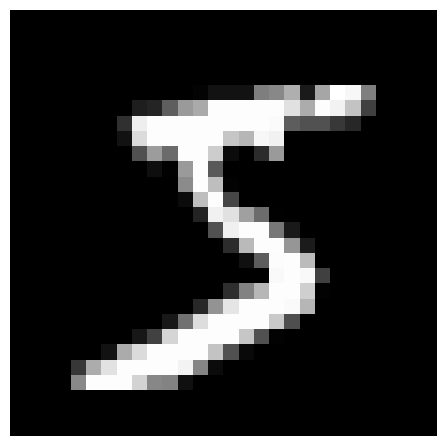

In [23]:
# Visualize the first image of the training set
first_image = x_train_orig[0]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.tight_layout()
plt.axis('off')

In [24]:
# check the image size
x_train_orig[0].shape

(28, 28)

In [25]:
# check the size of the original data
print("Shape of the original train data: {}".format(x_train_orig.shape))
print("Shape of the original test data: {}".format(x_test_orig.shape))

Shape of the original train data: (60000, 28, 28)
Shape of the original test data: (10000, 28, 28)


We have 60,000 images for training and 10,000 for testing. The image size is $28 \times 28$ pixels and they have only one channel (greyscale images).



### Preparing the data


We will apply a simple normalization of the data so that the pixel values are in the range (0,1). Although there exist python classes to apply this normalization, here we will use the simplest method, which is to divide the values by the maximum value to obtain values in the range between 0 and 1.

In [26]:

# Find the min and max values in the training set
v_min = np.min(x_train_orig)
v_max = np.max(x_train_orig)
print("Min. and max. values before normalization are {} and {}.".format(v_min, v_max))

# Normalization
x_train_orig = (x_train_orig - v_min) / (v_max - v_min)
x_test_orig = (x_test_orig - v_min) / (v_max - v_min)

print("Min. and max. values after normalization are {} and {}.".format(np.min(x_train_orig), np.max(x_train_orig)))

Min. and max. values before normalization are 0 and 255.
Min. and max. values after normalization are 0.0 and 1.0.


We will now adjust the shapes of the training and test data using 4 dimensions, as the last dimension must be 1 to indicate that the images are in grayscale (1 channel).

We do this because a convolutional layer expects at its input a 4-dimensional tensor with shape $(B,W,H,C)$ where $B$ is the batch size, $W$ and $H$ are respectively the width and weight of our images, and $C$ is the number of channels of the images ($C=1$ for greyscale images, $C=3$ for RGB color images, etc.)

Thus, we want our train and test data to have a shape of <code>(60000, 28, 28, 1)</code> and <code>(10000, 28, 28, 1)</code> respectively.

In [27]:
x_train = x_train_orig.reshape(60000,28,28,1)
x_test = x_test_orig.reshape(10000,28,28,1)

print("Shape of the train data: {}".format(x_train.shape))
print("Shape of the test data: {}".format(x_test.shape))

Shape of the train data: (60000, 28, 28, 1)
Shape of the test data: (10000, 28, 28, 1)


Finally, we will encode the values of the class labels as `one-hot` vectors. The aim of this action is to convert the class label data to the same format of the output of our neural network, so they are directly comparable. For example, the output vector for an image with a 5 (class_label=5) would be encoded as follows [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.].

Notice that our target are one-hot vectors in a 10-dimensional space because we cave 10 classes (the numbers from 0 to 9).

To make this task easier, we will use the `to_categorial` function of` Keras.utils`.

In [28]:
y_train = to_categorical(y_train_orig)
y_test = to_categorical(y_test_orig)

print("Shape of y_train_orig is {} and the value of y_train_orig[0] is {}".format(y_train_orig.shape, y_train_orig[0]))
print("Shape of y_train is {} and the value of y_train[0] is {}".format(y_train.shape, y_train[0]))

Shape of y_train_orig is (60000,) and the value of y_train_orig[0] is 5
Shape of y_train is (60000, 10) and the value of y_train[0] is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Create the CNN model

We will use a `Sequential` model from Keras, which is very intuitive and easy to use. These types of models allow you to build the model by adding layer by layer. Specifically:

- The first layer we add will be a convolutional layer with the following properties:
   - Number of kernels (neurons): 64
   - Size of the kernels: 3x3
   - Kernel activation: relu
- A *Flatten* layer must then be added to connect the output of the convolutional layer with the input of a dense layer.
- Finally, we add a dense output layer, which will therefore have as many neurons as classes (10). The activation of this last layer will be the *softmax* function. This way the final prediction of the model will be the class with the highest probability.

The following code implements the CNN model.

In [29]:
num_classes = 10

model = Sequential()

# Add each layer to the model
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(num_classes, activation="softmax"))

### Compile the model

Once the model has been defined, it must be compiled prior to the training process. In this case we will use the `Adam` optimization algorithm, the `categorical_crossentropy` loss function and the `accuracy` metric.

In [30]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Training the model

At this point we can train the model. We will make the model see each image in the training set 10 different times (i.e. `epochs` = 10), set a` batch_size` value equal to 128, and use the test set to validate the process after each training epoch.

In [31]:
n_epochs = 10

mfit = model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test), 
                 batch_size=128, 
                 epochs=n_epochs)

Epoch 1/10
469/469 [==============================] - 10s 21ms/step - loss: 0.2238 - accuracy: 0.9364 - val_loss: 0.0881 - val_accuracy: 0.9737
Epoch 2/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0742 - accuracy: 0.9783 - val_loss: 0.0641 - val_accuracy: 0.9797
Epoch 3/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0514 - accuracy: 0.9852 - val_loss: 0.0642 - val_accuracy: 0.9800
Epoch 4/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0397 - accuracy: 0.9883 - val_loss: 0.0589 - val_accuracy: 0.9804
Epoch 5/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0329 - accuracy: 0.9899 - val_loss: 0.0609 - val_accuracy: 0.9800
Epoch 6/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0263 - accuracy: 0.9920 - val_loss: 0.0609 - val_accuracy: 0.9821
Epoch 7/10
469/469 [==============================] - 14s 30ms/step - loss: 0.0207 - accuracy: 0.9940 - val_loss: 0.0615 - val_accuracy: 0

### Plot the accuracy and loss over time

Next, we create a function that will allow us to see the evolution of the *accuracy* and the *loss* values in both the training and test sets at every epoch of the training process.

In [35]:
# plot accuracy and loss
def plot_prediction(n_epochs, mfit):
    N = n_epochs
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Training Loss and Accuracy')
    
    ax1.plot(np.arange(0, N), mfit.history["accuracy"], label="train")
    ax1.plot(np.arange(0, N), mfit.history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    
    ax2.plot(np.arange(0, N), mfit.history["loss"], label="train")
    ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    
    plt.show()

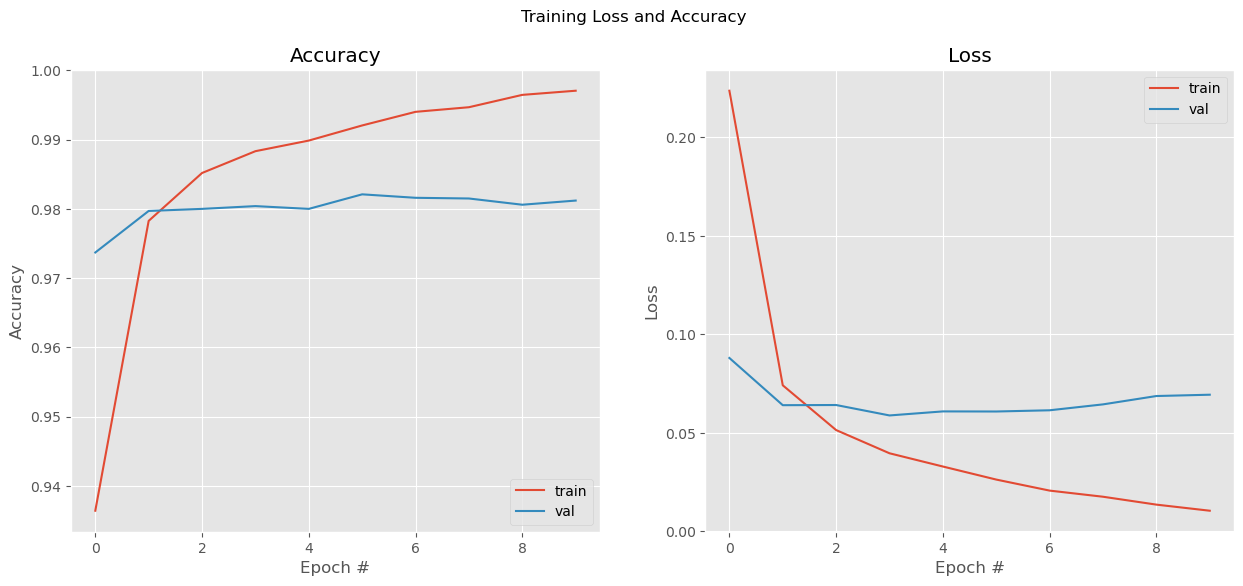

In [36]:
plot_prediction(n_epochs, mfit)

We appreciate a clear overfitting of the model during training. Remember we can set an early stopping rule in keras to stop training as soon as the validation loss does not improve for some iterations.

Nonetheless the final validation accuracy of this simple CNN model achieves 98.23%, which is very good. 

### Model predictions

Finally, we can use the trained model to predict a class for any given image. Let's see how to make predictions for the first four images of the test set and check whether the results are correct or not.

1/1 [==============================] - 0s 22ms/step


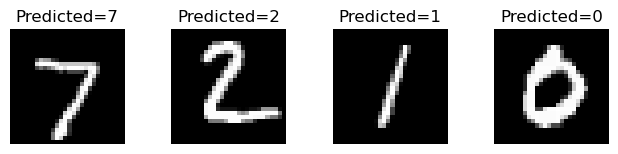

In [39]:
# Get predictions for the first four images of the test set
predictions = model.predict(x_test[:4])


for i in range(predictions.shape[0]):
    # Visualize the image and predicted vs. real class label
    image = x_test[i]
    pixels = image.reshape((28, 28))
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.imshow(pixels, cmap='gray')
    # Check the predicted class value for those images
    ax.set_title('Predicted={}'.format(np.argmax(predictions[i,:])),{'fontsize':12})
    ax.axis('off')


### EXERCISE

Create a new model with the following convolutional model with Dropout and train it on MNIST data. Once trained, test it and compare the results with the single-layer model. 

- First Layer: Convolutional Layer (CONV1):
   - Number of kernels: 32
   - Size of the kernels: 3x3
   - Kernel activation: relu

- Second Layer: Max Pooling Layer (POOL1):

   - Pool size: 2x2
    
- Third Layer: Convolutional Layer (CONV2):
   - Number of kernels: 64
   - Size of the kernels: 3x3
   - Kernel activation: relu
        
- Fourth Layer: Max Pooling Layer (POOL2):

    - Pool size: 2x2
    
- Fifth Layer: Flatten layer(FLAT1)
        
- Sixth Layer: Dropout layer(DROP1):

    - Droupout_rate: 0.5
    
- Seventh Layer: Dense layer(FC1):

    - Number of output neurons: 10
    - Activation function: softmax
    